In [ ]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# FourCastNet: A practical introduction to a state-of-the-art deep learning global weather emulator

Author(s):
*   Jaideep Pathak, NVIDIA, jpathak@nvidia.com
*   Shashank Subramanian, LBNL, shashanksubramanian@lbl.gov
*   Peter Harrington, LBNL, pharrington@lbl.gov
*   Thorsten Kurth, NVIDIA, tkurth@nvidia.com
*   Andre Graubner, NVIDIA, agraubner@nvidia.com
*   Morteza Mardani, NVIDIA, mmardani@nvidia.com
*   David Hall, NVIDIA, dhall@nvidia.com
*   Karthik Kashinath, NVIDIA, kkashinath@nvidia.com
*   Anima Anandkumar, NVIDIA, aanandkumar@nvidia.com


This notebook is a tutorial for running FourCastNet, a state-of-the-art global high-resolution weather model surrogate, to generate short time-scale forecasts of important atmospheric variables.

# Table of Contents


*   [Overview](#overview)
*   [Climate Impact](#climate-impact)
*   [Target Audience](#target-audience)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)


<a name="overview"></a>
# Overview

This tutorial provides examples to demonstrate the general workflow of working with global atmospheric data and using FourCastNet, a deep learning based weather model, to obtain short to medium-range forecasts of crucial atmospheric variables such as surface wind velocities. FourCastNet can perform these forecasts in a matter of seconds, orders of magnitudes faster and more energy efficient than numerical weather prediction models with accuracy close to that of the best NWP models based on partial differential equation solvers. FourCastNet is the current state-of-the-art deep learning-based surrogate for weather models operating at an unprecedented resolution of 25km. FourCastNet is built using standard machine learning libraries and can be deployed in inference easily. Here, we aim to demonstrate to our users the following:
* work with global weather data from the most comprehensive atmpospheric reanalysis public dataset ERA5 (data assimilated predictions of the historical global atmoshpheric state).
* use FourCastNet on inputs from this dataset to generate short-time scale forecasts of several important atmospheric variables in a matter of seconds.
* visualize the global predictions and compute key metrics to evaluate the forecast skill.
* capture several different types of significant extreme events such as hurricanes and atmospheric rivers.

FourCastNet was trained using significant computational resources that are not always readily available to the academic research community. The trained model weights, code and datasets are shared freely in order to enable broader access to our research. This tutorial is a step towards increasing the accessibility of our work.

Reference:
1. [Pathak el al., 2022](https://arxiv.org/abs/2202.11214)
2. [Github](https://github.com/NVlabs/FourCastNet)

<a name="climate-impact"></a>
# Climate Impact
Accurate, reliable, and efficient means of forecasting global weather patterns are of paramount importance to our ability to mitigate and adapt to climate change. Currently, real-time weather forecasting requires repeated numerical simulation and data assimilation cycles on dedicated supercomputers, which restricts the ability to make reliable, high-resolution forecasts to a handful of organizations. However, recent advances in deep learning, specifically the FourCastNet model, have shown that data-driven approaches can forecast important atmospheric variables with excellent skill and comparable accuracy to standard numerical methods, but at orders-of-magnitude lower computational and energy cost during inference, enabling larger ensembles for better probabilistic forecasts. Forecasting these atmospheric variables can have important implications to various areas such as wind and water resource planning, extreme atmospheric events (hurricanes, atmospheric rivers, heat waves) prediction for disaster prepardeness.

We envision continuous improvements and development of FourCastNet. This, we hope, will enable the leap from accurate medium-range weather forecasts to seasonal and sub-seasonal forecasts all the way up to long-term probabilistic projections of future climate scenarios conditioned on key inputs such as the rising CO2 concentration.

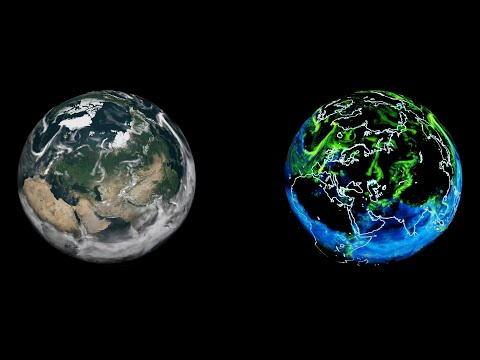

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('nuT_U1AQz3g')

<a name="target-audience"></a>
# Target Audience

The intended audience for this tutorial is anyone interested in using deep learning for research in climate science as well as theoretical and operational weather forecasting. Meteorologists and researcher practitioners in numerical weather prediction, climate science, and earth science will have the most immediate applications for models like FourCastNet, which forecasts atmospheric dynamics with accuracy and speed. Beyond scientific domains, stakeholders in wind energy resource planning, water resource planning, and disaster preparedness may also be interested in tools such as FourCastNet.
Because the earth sciences domain has a lot of rich, extremely high-resolution datasets that have different characteristics from typical natural image or video datasets, this tutorial would also be of interest to the general machine learning community. ML practitioners who wish to build better spatiotemporal modeling neural network architectures would benefit from the introduction to the FourCastNet codebase with its well-curated dataset, SOTA accuracy, performance intensive data loading and distributed computing workflows.



<a name="background-and-prereqs"></a>
# Background & Prerequisites
Basic experience in ML models and PyTorch. Prior background in atmospheric science is not expected.

In [ ]:
# libraries
import os, sys, time
import numpy as np
import h5py
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

<a name="software-requirements"></a>
# Software Requirements
Colab provides a PyTorch environment with the bulk of the necessary Python packages. The [offical FourCastNet Dockerfile](https://github.com/NVlabs/FourCastNet/blob/master/docker/Dockerfile) specifies the additional packages needed to run the code, but since Colab doesn't support Docker we install these via pip below.

In [ ]:
# Skip the below if already installed
!pip install ruamel.yaml einops timm
# clone fourcastnet
!git clone https://github.com/NVlabs/FourCastNet.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 6.5 MB/s 
     |████████████████████████████████| 41 kB 465 kB/s 
     |████████████████████████████████| 548 kB 49.8 MB/s 
     |████████████████████████████████| 500 kB 43.5 MB/s 
     |████████████████████████████████| 163 kB 51.6 MB/s 
Cloning into 'FourCastNet'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 48 (delta 9), reused 48 (delta 9), pack-reused 0
Unpacking objects: 100% (48/48), done.


<a name="data-description"></a>
# Data Description
  FourCastNet was trained on the publicly available [ERA5](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation) dataset, provided by the European Center for Medium-range Weather Forecasts (ECMWF). ECMWF is a premier operational and research organization at the cutting edge of Numerical Weather Prediction. The ERA5 dataset consists of hourly estimates of forecasts of several atmoshperic variables at a [latitude and longitude resolution of 0.25 degrees](https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference), from the surface of the earth to roughly 100 km altitude. ERA5 is an atmospheric reanalysis dataset and is the result of an optimal combination of observations from various measurement sources and the output of a numerical weather prediction model using a Bayesian estimation process called data-assimilation. The dataset is essentially a reconstruction of the optimal estimate of the observed history of the Earth’s atmosphere. While the ERA5 dataset has several prognostic variables available at 37 vertical levels with an hourly resolution, computational and data limitations along with other operational considerations for DL models restricts our choice, based on physical reasoning, to a subset of these available variables. The current release of FourCastNet is trained on 20 prognostic variables (see reference for further details, all variables are also described in this notebook). The ERA5 dataset predictions are defined on a spherical geometry which is interpolated to a latitude-longitude representation. Following this, each of these 20 variables is represented as a 2D field of shape (721x1440) pixels. Further, we also subselect these predictions at a temporal resolution of 6 hours for computational reasons. Hence, the complete dataset consists of tensors at 6 hourly intervals of shape (20x721x1440). While we do not train the model in this notebook, we show users the evaluation pipeline. For this, we subselect few timesteps from a testing year of 2018 for illustrative purposes.

Interested users are encouraged to download all the rest of the processed 2018 dataset from the Globus download link at the github [page](https://github.com/NVlabs/FourCastNet). Users are also encouraged to use the helper scripts provided in the github code to pre-process their own ERA5 data for use with FourCastNet.

## Data Download
The following downloads a sample of the data that will fit in Colab's available disk space. As mentioned before, we take a few timesteps from the 2018 test set as demonstrative examples.

The directory structure of the downloaded data reflects that of the [full FourCastNet dataset](https://github.com/NVlabs/FourCastNet) available for download, but is missing the train and validation sets.

In [ ]:
!wget https://portal.nersc.gov/project/m4134/ccai_demo.tar
!tar -xvf ccai_demo.tar
!rm ccai_demo.tar

--2022-11-11 19:47:36--  https://portal.nersc.gov/project/m4134/ccai_demo.tar
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.111, 128.55.206.110, 128.55.206.106, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3998497644 (3.7G) [application/x-tar]
Saving to: ‘ccai_demo.tar’

ccai_demo.tar       100%[===================>]   3.72G  44.4MB/s    in 2m 45s  

2022-11-11 19:50:21 (23.1 MB/s) - ‘ccai_demo.tar’ saved [3998497644/3998497644]

./ccai_demo/
./ccai_demo/additional/
./ccai_demo/additional/stats_v0/
./ccai_demo/additional/stats_v0/longitude.npy
./ccai_demo/additional/stats_v0/precip/
./ccai_demo/additional/stats_v0/precip/time_means.npy
./ccai_demo/additional/stats_v0/global_means.npy
./ccai_demo/additional/stats_v0/global_stds.npy
./ccai_demo/additional/stats_v0/latitude.npy
./ccai_demo/additional/stats_v0/land_sea_mask.npy
./ccai_demo/additional/stats_v0/time_means.npy
./cca

In [ ]:
# data and model paths
data_path = "./ccai_demo/data/FCN_ERA5_data_v0/out_of_sample"
data_file = os.path.join(data_path, "2018.h5")
model_path = "./ccai_demo/model_weights/FCN_weights_v0/backbone.ckpt"
global_means_path = "./ccai_demo/additional/stats_v0/global_means.npy"
global_stds_path = "./ccai_demo/additional/stats_v0/global_stds.npy"
time_means_path = "./ccai_demo/additional/stats_v0/time_means.npy"
land_sea_mask_path = "./ccai_demo/additional/stats_v0/land_sea_mask.npy"

In [ ]:
# Get the model config from default configs
sys.path.insert(1, './FourCastNet/') # insert code repo into path
from utils.YParams import YParams

In [ ]:
# We are going to use a default config. Please see github repo for other config examples
config_file = "./FourCastNet/config/AFNO.yaml"
config_name = "afno_backbone"
params = YParams(config_file, config_name)
print("Model architecture used = {}".format(params["nettype"]))

Model architecture used = afno


## Data Exploration

Here we can inspect the features and spatial structure of some important variables by plotting 2D visualizations. We list the order of atmospheric variables along the channel dimension for reference, and plot snapshots of the 10m horizontal wind (u10), 2m temperature, 500 hPa geopotential height (z500), and total column water vapor (tcwv). Clearly, each variable contains unique characteristics and intrinsic scales; for example, z500 exhibits much smoother features in general compared to the surface-level varaibles which are strongly affected by terrain and coastlines.

The variable keys are as follows:

* u10: zonal wind at 10m from surface
* v10: meridional wind at 10m from surface
* t2m: temperature at 2m from surface
* sp: surface pressure
* msl: pressure reduced to mean sea level
* tcwv: total / integrated column of atmospheric water vapor content
* u1000 (850, 500): zonal wind at pressure level 1000hPa (850hPa, 500hPa)
* v1000 (850, 500): meridional wind at pressure level 1000hPa (850hPa, 500hPa)
* t1000 (850, 500): temperature at pressure level 1000hPa (850hPa, 500hPa)
* z1000 (850, 500, 50): geopotential height at pressure level 1000hPa (850hPa, 500hPa, 50hPa)
* r500, r850: relative humidity at 500hPa, 850hPa


For more information on atmospheric variables, see the [ECMWF Parameter database](https://apps.ecmwf.int/codes/grib/param-db) or the copernicus climate data store catalogue of [single level](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) and [pressure level](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview) variables.




Total data shape: (40, 21, 721, 1440)


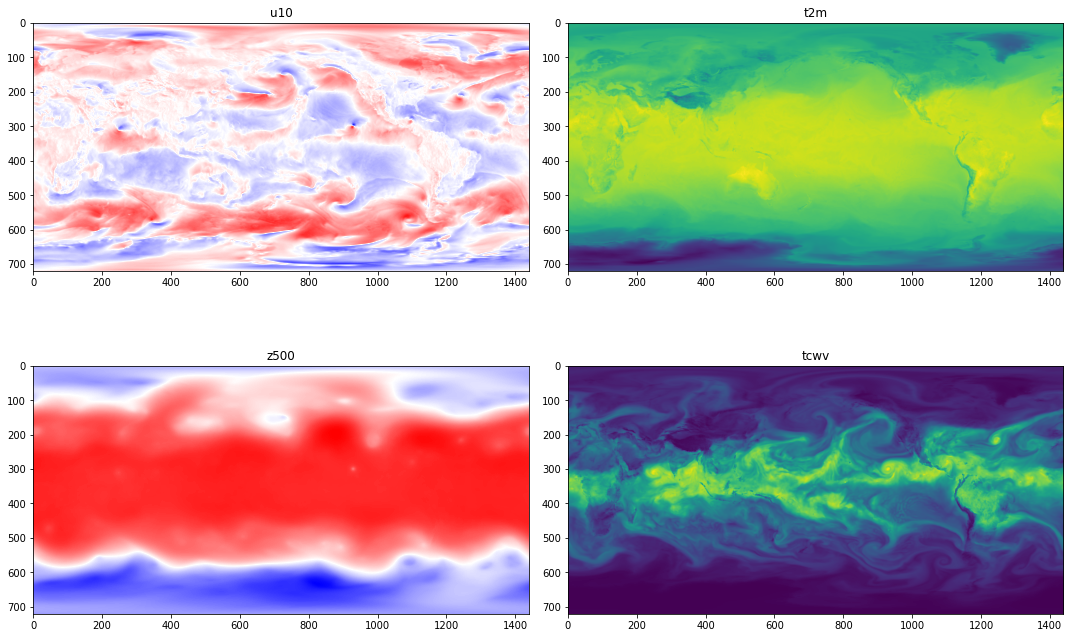

In [ ]:
'''
The ordering of atmospheric variables along the channel dimension is as follows:
'''
variables = ['u10',
             'v10',
             't2m',
             'sp',
             'msl',
             't850',
             'u1000',
             'v1000',
             'z1000',
             'u850',
             'v850',
             'z850',
             'u500',
             'v500',
             'z500',
             't500',
             'z50' ,
             'r500',
             'r850',
             'tcwv']

sample_data = h5py.File(data_file, 'r')['fields']
print('Total data shape:', sample_data.shape)
timestep_idx = 0
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i, varname in enumerate(['u10', 't2m', 'z500', 'tcwv']):
    cm = 'bwr' if varname == 'u10' or varname == 'z500' else 'viridis'
    varidx = variables.index(varname)
    ax[i//2][i%2].imshow(sample_data[timestep_idx, varidx], cmap=cm)
    ax[i//2][i%2].set_title(varname)
fig.tight_layout()

##Model Loading

We use the default AFNO backbone configuration as our forecasting model. The [AFNO or Adaptive Fourier Neural Operator](https://arxiv.org/abs/2111.13587) is a neural network architecture based on a vision transformer backbone with the self-attention spatial mixing (interaction between different pixels or image patches) replaced by mixing in the Fourier domain. The basic principle of a vision transformer is simple: the input tensor of size $C \times H \times W$ (channel width $C$, height $H$ and width $W$) is projected onto a grid of patches $D \times H/p \times W/p$, where $D$ is the projection embedding dimension and $p$ is the patch size. Each of these projected patches interact with each other (known as spatial mixing operation) in a transfomer block through a learned attention matrix (an $O(N^2)$ operation, with $N$ as number of patches) and the transformer block outputs a tensor of the same size as the input. We refer the user to the original vision transformer paper [Alexey Dosovitskiy et al. 2021](https://arxiv.org/abs/2010.11929) for details. The AFNO overcomes the quadratic complexity of mixing by performing the spatial mixing in the frequency domain using Fast Fourier Transforms and shared weights. We refer the user to [Pathak el al., 2022](https://arxiv.org/abs/2202.11214) for further details on the model architecture.

The model was trained on 64 GPUs for 6 hours using the configs defined here. We load pretrained weights for making our forecasts.

We refer the reader to [Pathak el al., 2022](https://arxiv.org/abs/2202.11214) for FourCastNet benchmark comparisons with state-of-the-art NWP models, i.e., the IFS model of the ECMWF (Figure 6) and prior benchmarks of deep learning data-driven weather models (Figure 10). A comparison of computational cost and energy efficiency is also presented in the referenced preprint in table 2.

![afno](https://drive.google.com/uc?id=1Y0mdVHzNIrPju_IactWUbkEdgchM9C0o)

In [ ]:
# import model
from networks.afnonet import AFNONet
from collections import OrderedDict

def load_model(model, params, checkpoint_file):
    ''' helper function to load model weights '''
    checkpoint_fname = checkpoint_file
    checkpoint = torch.load(checkpoint_fname)
    try:
        ''' FourCastNet is trained with distributed data parallel
            (DDP) which prepends 'module' to all keys. Non-DDP
            models need to strip this prefix '''
        new_state_dict = OrderedDict()
        for key, val in checkpoint['model_state'].items():
            name = key[7:]
            if name != 'ged':
                new_state_dict[name] = val
        model.load_state_dict(new_state_dict)
    except:
        model.load_state_dict(checkpoint['model_state'])
    model.eval() # set to inference mode
    return model

device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

# in and out channels: FourCastNet uses 20 input channels corresponding to 20 prognostic variables
in_channels = np.array(params.in_channels)
out_channels = np.array(params.out_channels)
params['N_in_channels'] = len(in_channels)
params['N_out_channels'] = len(out_channels)
params.means = np.load(global_means_path)[0, out_channels] # for normalizing data with precomputed train stats
params.stds = np.load(global_stds_path)[0, out_channels]
params.time_means = np.load(time_means_path)[0, out_channels]

# load the model
if params.nettype == 'afno':
    model = AFNONet(params).to(device)  # AFNO model
else:
    raise Exception("not implemented")
# load saved model weights
model = load_model(model, params, model_path)
model = model.to(device)

<a name="methodology"></a>
# Methodology

In this section, we describe the different steps to compute forecasts. After this tutorial, users should be able to:
* Prepare ERA5 data in the right format for FourCastNet
* Run FourCastNet inference for timesteps of interest
* Analyze the forecast skill and accuracy on extremes for any atmospheric variable predicted by FourCastNet
* Use FourCastNet to forecast the track of hurricanes

## Get training stats for normalization
First, we load the mean and standard deviation of all variables across the training dataset. This has been precomputed for convenience, as computing this over 40 years can be resource-intensive. Each mean and standard deviation is of size (20,). All the data is standardized with these values. Further, we also load a temporal mean field that represents the mean field of each variable across all the years: this represents the climatology (the general variation of the field over several years). This is used to compute metrics for evaluation, described later. The climatology is a tensor of size 721x1440 for each of the 20 variables. We discard data from the last row from all variables to get a tensor of shape 720x1440.

In [ ]:
# move normalization tensors to gpu
# load time means: represents climatology
img_shape_x = 720
img_shape_y = 1440

# means and stds over training data
means = params.means
stds = params.stds

# load climatological means
time_means = params.time_means # temporal mean (for every pixel)
m = torch.as_tensor((time_means - means)/stds)[:, 0:img_shape_x]
m = torch.unsqueeze(m, 0)
# these are needed to compute ACC and RMSE metrics
m = m.to(device, dtype=torch.float)
std = torch.as_tensor(stds[:,0,0]).to(device, dtype=torch.float)

print("Shape of time means = {}".format(m.shape))
print("Shape of std = {}".format(std.shape))

Shape of time means = torch.Size([1, 20, 720, 1440])
Shape of std = torch.Size([20])



## Define metrics to evaluate forecast skill
We use the following metrics to evaluate the quality and skill of our predictions:
* Weighted root mean squared error (RMSE) for a forecast variable $v$ at forecast time-step $l$ defined as:
\begin{align}
\mathrm{RMSE}(v, l)= \sqrt{\frac{1}{NM} \sum_{m=1}^{M} \sum_{n=1}^{N} L(m)\left({X}_{\text{pred}}(l)[v,j,k]-{X}_{\text{true}}(l)\left[v, j, k \right]\right)^{2}},
\end{align}
where  ${X}_{\text{pred/true}}(l)\left[v, m, n \right]$ represents the value of predicted (/true) variable $v$ at the location denoted by the grid co-ordinates $(m, n)$ at the forecast time-step $l$. Here, $L(m)$ is a latitude weighting factor to account for the curvature of the field defined on a sphere and is defined as:
\begin{align}
L(m)=\frac{\cos (\operatorname{lat}(m))}{\frac{1}{N_{\text {lat }}} \sum_{m}^{N_{\text {lat }}} \cos (\operatorname{lat}(m))}.
\end{align}
* Weighted anomaly correlation coefficient (ACC) for a forecast variable $v$ at forecast time-step $l$ defined as:
\begin{align}
\mathrm{ACC}(v, l)=\frac{\sum_{m, n} L(m) \tilde{{X}}_{\text{pred}}(l)\left[ v, m, n \right] \tilde{{X}}_{\text{true}}(l)\left[v, m, n\right]}{\sqrt{\sum_{m, n} L(m) \left( \tilde{{X} }_{\text{pred}}(l)\left[v, m, n\right]\right)^{2} \sum_{m, n} L(m) \left(\tilde{{X}}_{\text{true}}(l)\left[v, m, n\right]\right)^{ 2}}},
\end{align}
where $\tilde{{X}}_{\text{pred/true}}(l)\left[v, m, n \right]$ represents the long-term-mean-subtracted value of predicted (true) variable $v$ at the location denoted by the grid co-ordinates $(m, n)$ at the forecast time-step $l$. The long-term mean of a variable is simply the mean value of that variable over a large number of historical samples in the training dataset. The long-term mean-subtracted variables $\tilde{{X}}_{\text{pred/true}}$ represent the anomalies of those variables that are not captured by the long term mean values. The long-term means are precomputed into the time means tensor above.

In [ ]:
# define metrics from the definitions above
def lat(j: torch.Tensor, num_lat: int) -> torch.Tensor:
    return 90. - j * 180./float(num_lat-1)

def latitude_weighting_factor(j: torch.Tensor, num_lat: int, s: torch.Tensor) -> torch.Tensor:
    return num_lat * torch.cos(3.1416/180. * lat(j, num_lat))/s

def weighted_rmse_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    #takes in arrays of size [n, c, h, w]  and returns latitude-weighted rmse for each channel
    num_lat = pred.shape[2]
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)
    s = torch.sum(torch.cos(3.1416/180. * lat(lat_t, num_lat)))
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))
    result = torch.sqrt(torch.mean(weight * (pred - target)**2., dim=(-1,-2)))
    return result

def weighted_acc_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    #takes in arrays of size [n, c, h, w]  and returns latitude-weighted acc for each channel
    num_lat = pred.shape[2]
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)
    s = torch.sum(torch.cos(3.1416/180. * lat(lat_t, num_lat)))
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))
    result = torch.sum(weight * pred * target, dim=(-1,-2)) / torch.sqrt(torch.sum(weight * pred * pred, dim=(-1,-2)) * torch.sum(weight * target *
    target, dim=(-1,-2)))
    return result

## Setup autoregressive inference

Obtaining forecasts is done through an autoregressive loop: the initial condition of the atmospheric state is taken from the ERA5 dataset and is recursively passed through the FourCastNet model, i.e., the predicted forecasts are once again fed back into the input stream to get forecasts for several timesteps. We setup a helper function to run autoregressive inference given an initial condition and a prediction/forecast length.

![inf](https://drive.google.com/uc?id=1DvjQ95udGjEmrWjxJvVle4tn8H6Oc0T8)


In [ ]:
# autoregressive inference helper

def inference(data_slice, model, prediction_length, idx):
    # create memory for the different stats
    n_out_channels = params['N_out_channels']
    acc = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    rmse = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)

    # to conserve GPU mem, only save one channel (can be changed if sufficient GPU mem or move to CPU)
    targets = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)
    predictions = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)


    with torch.no_grad():
        for i in range(data_slice.shape[0]):
            if i == 0:
                first = data_slice[0:1]
                future = data_slice[1:2]
                pred = first
                tar = first
                # also save out predictions for visualizing channel index idx
                targets[0,0] = first[0,idx]
                predictions[0,0] = first[0,idx]
                # predict
                future_pred = model(first)
            else:
                if i < prediction_length - 1:
                    future = data_slice[i+1:i+2]
                future_pred = model(future_pred) # autoregressive step

            if i < prediction_length - 1:
                predictions[i+1,0] = future_pred[0,idx]
                targets[i+1,0] = future[0,idx]

            # compute metrics using the ground truth ERA5 data as "true" predictions
            rmse[i] = weighted_rmse_channels(pred, tar) * std
            acc[i] = weighted_acc_channels(pred-m, tar-m)
            print('Predicted timestep {} of {}. {} RMS Error: {}, ACC: {}'.format(i, prediction_length, field, rmse[i,idx], acc[i,idx]))

            pred = future_pred
            tar = future

    # copy to cpu for plotting/vis
    acc_cpu = acc.cpu().numpy()
    rmse_cpu = rmse.cpu().numpy()
    predictions_cpu = predictions.cpu().numpy()
    targets_cpu = targets.cpu().numpy()

    return acc_cpu, rmse_cpu, predictions_cpu, targets_cpu


First, we read a slice of data corresponding to the forecast length. Here, the initial condition is at 00:00 hours on October 7, 2018 UTC. This serves as an illustrative example because it highlights Hurricane Michael which underwent rapid intensification during the course of its four day trajectory.
We keep track of a specific channel for visualization purposes downstream; in principle, we can track all channels, but we restrict ourselves to one channel here because of limited GPU memory and RAM on Colab.

In [ ]:
# setup data for inference
dt = 1 # time step (x 6 hours)
ic = 0 # start the inference from here
prediction_length = 20 # number of steps (x 6 hours)

# which field to track for visualization
field = 'u10'
idx_vis = variables.index(field) # also prints out metrics for this field

# get prediction length slice from the data
print('Loading inference data')
print('Inference data from {}'.format(data_file))
data = h5py.File(data_file, 'r')['fields'][ic:(ic+prediction_length*dt):dt,in_channels,0:img_shape_x]
print(data.shape)
print("Shape of data = {}".format(data.shape))

Loading inference data
Inference data from ./ccai_demo/data/FCN_ERA5_data_v0/out_of_sample/2018.h5
(20, 20, 720, 1440)
Shape of data = (20, 20, 720, 1440)


Before we run inference, we standardize the data with precomputed means and standard deviations. In this tutorial, we keep track of metrics for the field "u10", which represents the horizontal component of the surface wind velocities. The outputs track the weighted RMSE and ACC values for "u10" as a function of timestep.

In [ ]:
# run inference
data = (data - means)/stds # standardize the data
data = torch.as_tensor(data).to(device, dtype=torch.float) # move to gpu for inference
acc_cpu, rmse_cpu, predictions_cpu, targets_cpu = inference(data, model, prediction_length, idx=idx_vis)

Predicted timestep 0 of 20. u10 RMS Error: 0.0, ACC: 1.0
Predicted timestep 1 of 20. u10 RMS Error: 0.5595946907997131, ACC: 0.9900789260864258
Predicted timestep 2 of 20. u10 RMS Error: 0.7682855725288391, ACC: 0.9802855253219604
Predicted timestep 3 of 20. u10 RMS Error: 0.8545156121253967, ACC: 0.9751376509666443
Predicted timestep 4 of 20. u10 RMS Error: 0.9780221581459045, ACC: 0.966325044631958
Predicted timestep 5 of 20. u10 RMS Error: 1.072445273399353, ACC: 0.9600212574005127
Predicted timestep 6 of 20. u10 RMS Error: 1.2340998649597168, ACC: 0.9463505148887634
Predicted timestep 7 of 20. u10 RMS Error: 1.3775664567947388, ACC: 0.9345251321792603
Predicted timestep 8 of 20. u10 RMS Error: 1.5805360078811646, ACC: 0.9138075113296509
Predicted timestep 9 of 20. u10 RMS Error: 1.7355384826660156, ACC: 0.9003414511680603
Predicted timestep 10 of 20. u10 RMS Error: 1.9263551235198975, ACC: 0.8789008259773254
Predicted timestep 11 of 20. u10 RMS Error: 2.123239278793335, ACC: 0.8569

*Historically, this forecast, using numerical weather prediction models, should have required an entire supercomputer with thousands of cores to run; with FourCastNet, the forecast is obtained in a matter of seconds on a single GPU on Colab!*

<a name="results-and-discussion"></a>
# Results & Discussion
Using the saved tensors from our inference run, we can now evaluate our forecasts.

## Get quantitative metrics to evaluate forecasts
We plot the ACC and RMSE as a function of forecast time. In practice, ACC values above 0.6 are considered to be useful forecasts. We observe that, for example, $u_{10}$ shows good performance up to 4 days. Slower moving fields, such as $z_{500}$ (geopotential height) show great performance for much longer time horizons. Users can change the `field` variable name to analyze the results for different atmospheric variables

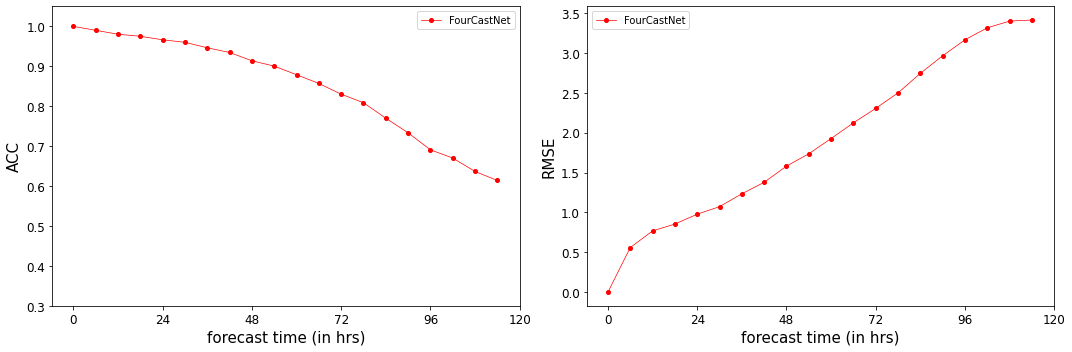

In [ ]:
# plot the acc and rmse metrics
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
start = 0
end = prediction_length #  < prediction_lenght forecast

field = 'u10' # change this to other fields such as z500
idx_metric = variables.index(field) # plot metrics for this field

hrs = np.arange(0, end*6, 6)
ax[0].plot(hrs, acc_cpu[start:end,idx_metric], "o-", label="FourCastNet", ms=4, lw=0.7, color="r")
ax[1].plot(hrs, rmse_cpu[start:end,idx_metric], "o-", label="FourCastNet", ms=4, lw=0.7, color="r")
ax[0].legend()
ax[1].legend()
fsz = "15"
xlist = np.arange(0,end*6+24,24)
ax[0].set_xlabel("forecast time (in hrs)", fontsize=fsz)
ax[1].set_xlabel("forecast time (in hrs)", fontsize=fsz)
ax[0].set_ylabel("ACC", fontsize=fsz)
ax[1].set_ylabel("RMSE", fontsize=fsz)
ax[0].set_ylim(0.3, 1.05)
ax[0].set_xticks(xlist)
ax[1].set_xticks(xlist)
ax[0].tick_params(axis='both', which='both', labelsize=12)
ax[1].tick_params(axis='both', which='both', labelsize=12)
fig.tight_layout()

## Visualize forecasts for qualitative assessment
We can visualize the spatiotemporal predictions for the channel tracked ($u_{10}$) and visually compare to the ground truth ERA5. We can observe that the predictions track the ground truth very well.

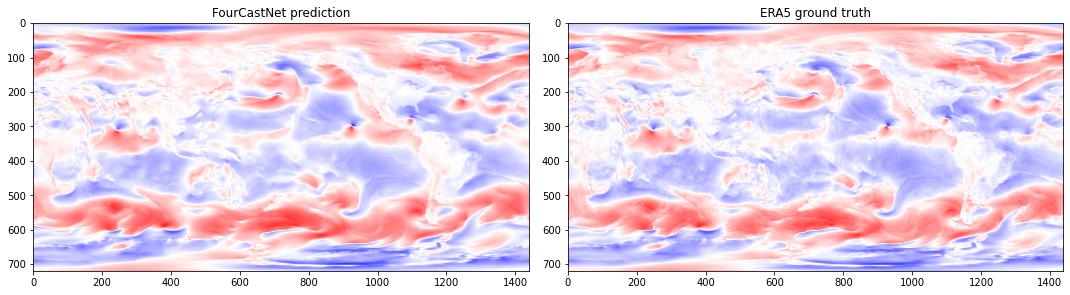

In [ ]:
# visualize spatiotemporal predictions
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
t = 2 # at 2x6 hours lead time
ax[0].imshow(predictions_cpu[t,0], cmap="bwr")
ax[1].imshow(targets_cpu[t,0], cmap="bwr")
ax[0].set_title("FourCastNet prediction")
ax[1].set_title("ERA5 ground truth")
fig.tight_layout()

## Assess instantaneous extremes
Quantifying extremes is a very important task for predicting rare atmospheric events such as hurricanes, heat waves, and heavy precipitation. We do so by looking at the top quantiles of each field at a given time step. We use 100 logarithmically-spaced quantile bins $Q = 1 - \{10^{-1}, ..., 10^{-4}\}$ (corresponding to percentiles $\{90\%, ..., 99.99\% \}$) to emphasize the most extreme values (generally, the FourCastNet predictions and ERA5 targets match closely up to around the 98$^\mathrm{th}$ percentile). We choose the 99.99$^{\mathrm{th}}$ as the top percentile  bin because percentiles beyond there sample less than 1000 pixels in each image and are subject to more variability.

In [ ]:
def quantiles(x, qtile):
    ''' helper to compute quantiles based on qtile of the field '''
    n, c, h, w = x.shape
    return np.quantile(x.reshape((n,c,h*w)), q=qtile, axis=-1).squeeze()

Let's compute these 100 bins for both our predictions and ERA5 over all the time steps.

In [ ]:
qs = 100
qlim = 4
qcut = 1
qtile = 1. - np.logspace(-qlim, -qcut, num=qs) # log-spaced bins for quantiles

# compute quantiles for the fields saved (channel idx_vis is saved out now)
era5_q = quantiles(targets_cpu, qtile)
mean_era5 = era5_q.mean(axis=1) # stats over different time points
std_era5 = era5_q.std(axis=1)

pred_q = quantiles(predictions_cpu, qtile) # for predictions
mean_pred = pred_q.mean(axis=1)
std_pred = pred_q.std(axis=1)

print(era5_q.shape, pred_q.shape)

(100, 20) (100, 20)


Plotting the quantiles, we observe that the predictions track the extremes well (but do underestimate the extremes from the 90$^{\mathrm{th}}$ percentile)

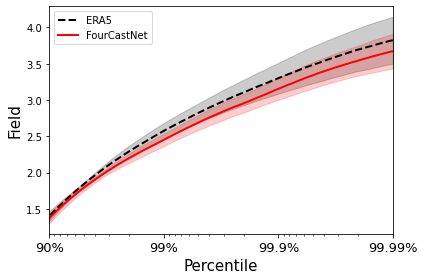

In [ ]:
# plot the extremes
plt.figure()
fs=15
ax = plt.gca() #axs[0]
qtiles = np.logspace(-qlim, -qcut, num=qs)
ax.plot(qtiles, mean_era5, 'k--', label='ERA5', lw=2)
ax.fill_between(qtiles, mean_era5+std_era5, mean_era5-std_era5, alpha=0.2, color='k')
ax.plot(qtiles, mean_pred, 'r-', label='FourCastNet', lw=2)
ax.fill_between(qtiles, mean_pred+std_pred, mean_pred-std_pred, alpha=0.2, color='r')
ax.set_xlim((qtiles[-1], qtiles[0]))
ax.set_xscale('log')
ax.set_xticks(ticks=10.**np.arange(-1,-qlim - 1, -1))
ax.set_xticklabels(labels=['%g%%'%(100.*(1. - 10.**q)) for q in np.arange(-1,-qlim - 1, -1)], fontsize=fs-2)
ax.set_xlabel('Percentile', fontsize=fs)
ax.set_ylabel('Field', fontsize=fs)
ax.legend()
plt.tight_layout()

## Hurricane tracking

In this section we demonstrate the use of FourCastNet for forecasting hurricane tracks. We will focus on Michael, a category 5 hurricane on the Saffir-Simpson Hurricane Wind Scale that made landfall in Florida in 2018 and caused
catastrophic damage. Michael started as a tropical depression around October 7, 2018 then underwent rapid intensification in the gulf of Mexico, reaching category 5 status before making landfall in Florida on October 10, 2018.

We can approximate the center of the hurricane by finding the minimum of the mean surface level pressure in the region of the globe where the tropical depression is forming. By recording the coordinates of the msl minima over time, we can record the track of the storm as it intensifies from a depression into catastrophic hurricane. The sample data from 2018 which we've downloaded in this notebook contains the initial condition on October 7, 2018 as the first time index, so we simply need to run autoregressive inference with the model starting there.

In [ ]:
# which field to track for visualization
field = 'msl' # mean surface level pressure
idx_vis = variables.index(field) # also prints out metrics for this field

acc_cpu_msl, rmse_cpu_msl, predictions_cpu_msl, targets_cpu_msl = inference(data, model, prediction_length, idx=idx_vis)

# destandardize the fields for msl
m_msl = params.means[idx_vis,0]
s_msl = params.stds[idx_vis,0]

pred_msl = s_msl*predictions_cpu_msl + m_msl
true_msl = s_msl*targets_cpu_msl + m_msl
print(pred_msl.shape, true_msl.shape) # destandardized forecasted and true msl fields

Predicted timestep 0 of 20. msl RMS Error: 0.0, ACC: 1.0
Predicted timestep 1 of 20. msl RMS Error: 38.01778793334961, ACC: 0.9986557960510254
Predicted timestep 2 of 20. msl RMS Error: 55.31366729736328, ACC: 0.9970652461051941
Predicted timestep 3 of 20. msl RMS Error: 61.87911605834961, ACC: 0.996441125869751
Predicted timestep 4 of 20. msl RMS Error: 77.74359130859375, ACC: 0.9944821000099182
Predicted timestep 5 of 20. msl RMS Error: 87.4363021850586, ACC: 0.9927594065666199
Predicted timestep 6 of 20. msl RMS Error: 107.86070251464844, ACC: 0.9885034561157227
Predicted timestep 7 of 20. msl RMS Error: 125.31654357910156, ACC: 0.984866201877594
Predicted timestep 8 of 20. msl RMS Error: 147.39910888671875, ACC: 0.9790379405021667
Predicted timestep 9 of 20. msl RMS Error: 173.34458923339844, ACC: 0.9707461595535278
Predicted timestep 10 of 20. msl RMS Error: 201.41444396972656, ACC: 0.9600927829742432
Predicted timestep 11 of 20. msl RMS Error: 227.37820434570312, ACC: 0.950437963

Now that we've run inference, let's compute and store the msl minima throughout the forecast period:

In [ ]:
# focus on this region: represents hurricane Michael focus
x_min = 1081
x_max = 1121
y_min = 201
y_max = 305

track_pred_x = []
track_pred_y = []
track_true_x = []
track_true_y = []


t_max = 14 # number of time steps to track the hurricane (roughly the number of steps to reach landfall)
timeaxis = np.arange(0,t_max)

for t in range(t_max):
  min_pressure_predicted = np.min(pred_msl[t,0,y_min:y_max,x_min:x_max])
  pred_y = np.where(pred_msl[t,0,y_min:y_max, x_min:x_max] == min_pressure_predicted)[0]
  pred_x = np.where(pred_msl[t,0,y_min:y_max, x_min:x_max] == min_pressure_predicted)[1]
  track_pred_x.append(pred_x[0])
  track_pred_y.append(pred_y[0])


  min_pressure_true = np.min(true_msl[t,0,y_min:y_max,x_min:x_max])
  true_y = np.where(true_msl[t,0,y_min:y_max, x_min:x_max] == min_pressure_true)[0]
  true_x = np.where(true_msl[t,0,y_min:y_max, x_min:x_max] == min_pressure_true)[1]
  track_true_x.append(true_x[0])
  track_true_y.append(true_y[0])

By plotting the msl minima of the forecast compared to that of the ground truth, we can see the predicted track closely matches the actual observed outcome for this hurricane:

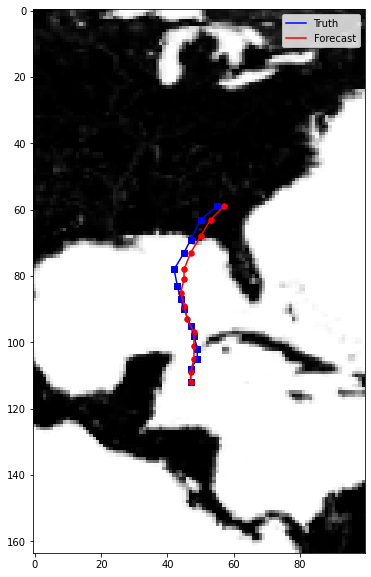

In [ ]:
offset = 30
lsm = np.load(land_sea_mask_path)[0:720] # land-sea mask to show coastlines
plt.figure(figsize=(30, 10))
ax = plt.gca()
ax.imshow(lsm[y_min-offset:y_max+offset, x_min-offset:x_max+offset], cmap = 'Greys')
plt.scatter(np.array(track_true_x) + offset , np.array(track_true_y) + offset, s = 30, marker = 's', c = 'b')
plt.plot(np.array(track_true_x) + offset , np.array(track_true_y) + offset, c = 'b', label="Truth")
plt.scatter(np.array(track_pred_x) + offset , np.array(track_pred_y) + offset, s = 30, marker = 'o', c = 'r')
plt.plot(np.array(track_pred_x) + offset , np.array(track_pred_y) + offset, c = 'r', label="Forecast")
plt.legend()

While we are somewhat resorce-limited running on Colab, note in general one could run an ensemble of forecasts by perturbing the initial conditions and model predictions with noise. We refer the users to [the paper](https://arxiv.org/abs/2202.11214) for more details on such an approach.

## Limitations
*   One of the limitations of FourCastNet is that it does not perform data assimilation with observations; we are dependent on a dataset such as ERA5 to provide us real-time initial conditions. However, once obtained, the forecasts for a week or two can be generated blazingly fast
*   The current resolution of 25 km is still coarse to capture finer scale structures of sub-grid processes. We would have to go to 5 km scale (and finer) for resolving these. Of course, at these scales, compute and memory challenges are significant. We refer the reader to [Kurth et al. (2022)](https://arxiv.org/abs/2208.05419) for a model-parallel version to deal with these high resolutions. This is still work-in-progress.
* FourCastNet is a fully data-driven model without physics constraints.
This means that the model could be subject to some unphysical instabilities that are not present in traditional numerical weather predicition. We are working on introducing physics constraints into the next version of FourCastNet.
* Currently, FourCastNet is intended as a weather model and its behaviour on climate time scales is not understood well. We, eventually, envision a coupling between a climate model output and FourCastNet in order to understand extreme weather in future climate scenarios.

## Next Steps

In this notebook, we have seen how to format and normalize ERA5 data and run inference with FourCastNet, storing forecast outputs and using them for analysis tasks like evaluating forecast skill, assessing instantaneous extremes, and predicting hurricane tracks. However, these general steps enable users to use FourCastNet for a much wider set of use-cases.

One immediate application of FourCastNet in the data-driven modeling area is to use the pretrained backbone model as a building block or foundation for training other models to make predictions for a specific variable or region of interest. In this setting, FourCastNet outputs can be used as initial or boundary conditions for tasks not included in the general forecasting task used for pretraining. For example, one could train a model to predict a specific variable of interest not included in the main FourCastNet backbone (e.g., 100m winds which may be of interest to wind energy stakeholders), or train a regional high-resolution model which depends on FourCastNet for boundary conditions.

While this notebook did not demonstrate actual model training due to resource constraints, the main FourCastNet repository includes code for training and we encourage users to now work on training the model themselves. This is complementary to the aforementioned idea of adapting FourCastNet for whatever use-cases are most important to a given stakeolder; the pretrained model weights provide a good initialization for fine-tuning, so can even accelerate the time-to-solution even for novel tasks that were not included in the main model training.